<a href="https://colab.research.google.com/github/motho17/U-SAM-hybrid-model/blob/main/unet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **U-Net Model implementation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

Data Loading and preparation

In [3]:
!unzip '/content/drive/MyDrive/BraTs2.zip' -d '/content/BraTs2020'

Streaming output truncated to the last 5000 lines.
  inflating: /content/BraTs2020/content/BraTs2/3830/t2.jpg  
  inflating: /content/BraTs2020/content/BraTs2/3830/seg.jpg  
   creating: /content/BraTs2020/content/BraTs2/4529/
  inflating: /content/BraTs2020/content/BraTs2/4529/t1ce.jpg  
  inflating: /content/BraTs2020/content/BraTs2/4529/flair.jpg  
  inflating: /content/BraTs2020/content/BraTs2/4529/t1.jpg  
  inflating: /content/BraTs2020/content/BraTs2/4529/t2.jpg  
  inflating: /content/BraTs2020/content/BraTs2/4529/seg.jpg  
   creating: /content/BraTs2020/content/BraTs2/20978/
  inflating: /content/BraTs2020/content/BraTs2/20978/t1ce.jpg  
  inflating: /content/BraTs2020/content/BraTs2/20978/flair.jpg  
  inflating: /content/BraTs2020/content/BraTs2/20978/t1.jpg  
  inflating: /content/BraTs2020/content/BraTs2/20978/t2.jpg  
  inflating: /content/BraTs2020/content/BraTs2/20978/seg.jpg  
   creating: /content/BraTs2020/content/BraTs2/27801/
  inflating: /content/BraTs2020/conten

Split the data into training and validation

In [4]:
from glob import glob
import os
import numpy as np
imgs_dir='/content/BraTs2020/content/BraTs2'
all_dirs = glob (f'{imgs_dir}/*')
all_dirs = all_dirs
# print(len(all_dirs))
all_dirs.sort()
def shuffle_split (all_dirs, val_pct = 0.15, seed = 99):
    """ shuffling dataset with random state and split to train and valid """
    n_val = int (len (all_dirs) * val_pct)
    np.random.seed (seed)
    idx = np.random.permutation (len (all_dirs))
    all_dirs = np.array (all_dirs) [idx]

    return all_dirs [n_val:], all_dirs [:n_val]

train_dirs, valid_dirs = shuffle_split (all_dirs, seed = 1)
print(len(valid_dirs)), print(len(train_dirs))

5307
30073


(None, None)

A class for loading and preprocessing the images,the preprocessing steps include normalization,augmentation,resizing and stacking the images

In [5]:
from glob import glob
import os
import numpy as np
import torch
import albumentations as A
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#data preprocessing class
#@title brats 8
class BratsDataset (Dataset):
  def __init__ (self, img_dirs, modality_types, transform = None):
      self.img_dirs = img_dirs
      self.transform = transform

  def __len__ (self):
      return len (self.img_dirs)

  def __getitem__ (self, index):
      imgs_path = self.img_dirs [index]
      image = self.concat_imgs (imgs_path)
      mask = np.array (Image.open (f'{imgs_path}/seg.jpg'))
      mask = (mask / 255 * 4).round ()
      mask = self.preprocess_mask_labels(mask)

      image = image.transpose(2, 1, 0)  # (B, H, W, C) to (B, C, H, W)
      mask = mask.transpose(2, 1, 0)  # (C, H, W) to (B, C, H, W)
      # print(image.shape)
      # print(mask.shape)


      if self.transform is not None:
          augmented = self.transform(image = image, mask = mask)
          image = augmented ['image']
          mask = augmented ['mask']
      image = image.permute(0,1,2)  # (B, H, W, C) to (B, C, H, W)
      mask = mask.permute(2, 0, 1)  # (C, H, W) to (B, C, H, W)
      # print(image.shape)
      # print(mask.shape)
      bboxes = self.get_bounding_box(mask)


      # return image.astype(float), mask.astype(float),bboxes
      # return image.float(), mask.float(),bboxes
      # return image.astype(np.float), mask.astype(np.float),bboxes

      # mask = mask.to(device=DEVICE)
      # image = image.to(device=DEVICE)

      return image.float(),mask.float()


  def concat_imgs (self, path: str):
      types = []
      for modality_type in modality_types:
          img = np.array (Image.open (f'{path}/{modality_type}.jpg'))
          img = self.normalize(img)
          types.append (img)
#         cat_img = np.concatenate (types, axis = -1)

      return np.array(types)
  def get_bounding_box(self, mask):
    ground_truth_map = mask[0]# Extract the first channel of the mask

    # Find the indices of non-zero elements in the ground truth map
    y_indices, x_indices = np.where(ground_truth_map > 0)

    # Calculate the minimum and maximum values for x and y coordinates
    try:
      x_min = np.min(x_indices)
      y_min = np.min(y_indices)
      x_max = np.max(x_indices)
      y_max = np.max(y_indices)

    except ValueError:
      x_min = 0
      y_min = 0
      x_max = 0
      y_max = 0
    bboxes = np.array([x_min, y_min, x_max, y_max])

    return bboxes

  def preprocess_mask_labels(self, mask: np.ndarray):
      mask_WT = np.zeros(mask.shape)
      mask_WT[mask == 2] = 1

      mask_TC = np.zeros(mask.shape)
      mask_TC[mask == 1] = 1

      mask_ET = np.zeros(mask.shape)
      mask_ET[mask == 3] = 1

      mask_BG = np.zeros(mask.shape)
      mask_BG[mask == 0] = 1

      mask = np.stack([mask_WT, mask_TC, mask_ET])#, mask_BG
      # mask = np.moveaxis(mask, (0, 1, 2), (0, 2, 1))
      return mask

  def normalize(self, data: np.ndarray):
      data_min = np.min(data)
      if np.max(data) == 0:
          return data
      if (np.max(data) - data_min) == 0:
          return data / data_min

      return (data - data_min) / (np.max(data) - data_min)


modality_types = ['flair', 't1', 't1ce']#,'t2'

trn_tfms = A.Compose([
    A.Resize(height=256, width=256),
    A.Resize(height=256, width=256),
    A.Rotate (limit = 35, p = 1.0),
    A.HorizontalFlip (p = 0.5),
    A.VerticalFlip (p = 0.1),
    ToTensorV2(),
])

val_tfms = A.Compose([
    A.Resize(height=256, width=256),
    ToTensorV2(),
])



Data Loader

In [6]:
train_ds = BratsDataset(train_dirs, modality_types,transform = trn_tfms)
train_dl = DataLoader(train_ds, batch_size = 32, shuffle = False, num_workers = 4, pin_memory = True)

valid_ds = BratsDataset(valid_dirs, modality_types,transform = val_tfms)
valid_dl = DataLoader(valid_ds, batch_size = 16, shuffle = False, num_workers = 2, pin_memory = True)


U-net model class defininition

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        x = self.sigmoid(x)
        return x


# Get UNet model
model = UNet()

In [8]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
model.to(device =  DEVICE)

UNet(
  (down_conv1): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv2): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [10]:
!pip install segmentation-models-pytorch==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 285.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 32.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12404 sha256=f96dd8a4c3dc7df5d811930c75e97a302d0b288ede88a5ee22aa7042b49dfeff
  Stored in directory: /root/.cache/pip/wheels/61/3a/b0/0b4c443c380bd934701b0a25e4aed76479e4fcaf1a6f955664
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=7cd3527d54e70ac70d44b2d64b43c0b0559c33555195612d4b27c7e14237764a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


Model training

In [11]:

import keras
from keras import backend as K
from torch.optim import Adam

from typing import Tuple
from glob import glob
import tensorflow as tf
import torch.nn as nn
import albumentations as album
import segmentation_models_pytorch as smp
import time

import matplotlib.patches as patches

TRAINING = True

# Set num of epochs
EPOCHS = 50

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params= model.parameters(), lr=0.00001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/drive/MyDrive/SAM/unet/best_model.pth'):
    model = torch.load('/content/drive/MyDrive/SAM/unet/best_model.pth', map_location=DEVICE)


In [12]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [13]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_dl)
        valid_logs = valid_epoch.run(valid_dl)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 332/332 [00:21<00:00, 15.77it/s, dice_loss - 0.9747, iou_score - 0.164]
Model saved!

Epoch: 1
valid: 100%|██████████| 332/332 [00:20<00:00, 15.93it/s, dice_loss - 0.9709, iou_score - 0.1672]
Model saved!

Epoch: 2
valid: 100%|██████████| 332/332 [00:20<00:00, 16.01it/s, dice_loss - 0.9659, iou_score - 0.2047]
Model saved!

Epoch: 3
valid: 100%|██████████| 332/332 [00:20<00:00, 15.86it/s, dice_loss - 0.9586, iou_score - 0.2614]
Model saved!

Epoch: 4
valid: 100%|██████████| 332/332 [00:20<00:00, 15.85it/s, dice_loss - 0.9489, iou_score - 0.2769]
Model saved!

Epoch: 5
valid: 100%|██████████| 332/332 [00:20<00:00, 15.97it/s, dice_loss - 0.9361, iou_score - 0.3085]
Model saved!

Epoch: 6
valid: 100%|██████████| 332/332 [00:20<00:00, 15.93it/s, dice_loss - 0.9192, iou_score - 0.3595]
Model saved!

Epoch: 7
valid: 100%|██████████| 332/332 [00:21<00:00, 15.70it/s, dice_loss - 0.8953, iou_score - 0.4106]
Model saved!

Epoch: 8
valid: 100%|██████████| 332/332

In [14]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(valid_dl)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 332/332 [00:20<00:00, 15.89it/s, dice_loss - 0.1155, iou_score - 0.7942]
Evaluation on Test Data: 
Mean IoU Score: 0.7942
Mean Dice Loss: 0.1155


In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

test_logs = test_epoch.run(test_dl)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {test_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {test_logs['dice_loss']:.4f}")

In [ ]:
train_logs_list
losses = []
for i in range(len(train_logs_list)):
  first_key,first_value = list(train_logs_list[i].items())[0]
  losses.append(first_value)


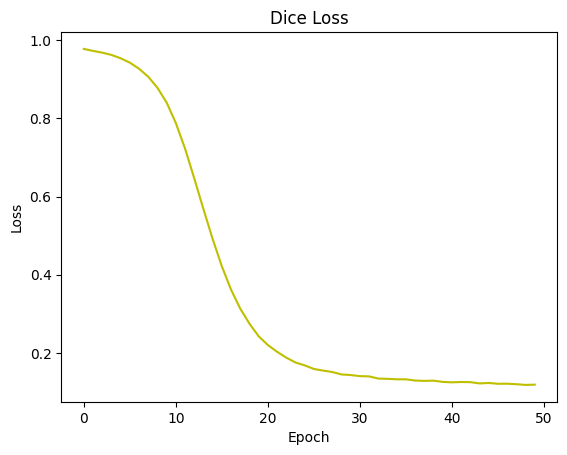

In [16]:
import os
join = os.path.join
work_dir = './content/drive/MyDrive/SAM'
task_name = 'Deeplab'
model_save_path = join(work_dir, task_name)
# plot loss
plt.plot(losses,'y')
plt.title('Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
# plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [17]:
import pandas as pd

train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
dice_loss,0.977824,0.972772,0.968315,0.962441,0.953907,0.942736,0.927126,0.906620,0.878365,0.840546,...,0.124498,0.125324,0.124906,0.121715,0.122893,0.120836,0.120933,0.119718,0.117855,0.118514
iou_score,0.064376,0.151678,0.179100,0.206795,0.240058,0.269979,0.308997,0.346751,0.392754,0.436019,...,0.779773,0.778389,0.779010,0.783935,0.782037,0.785254,0.785089,0.786952,0.789878,0.788844


Saving the logs in my local computer

In [18]:
from google.colab import files
valid_logs_df.to_csv('valid_logsnet_df.csv', encoding = 'utf-8-sig')
files.download('valid_logsnet_df.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
from google.colab import files
train_logs_df.to_csv('train_logsnet_df.csv', encoding = 'utf-8-sig')
files.download('train_logsnet_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

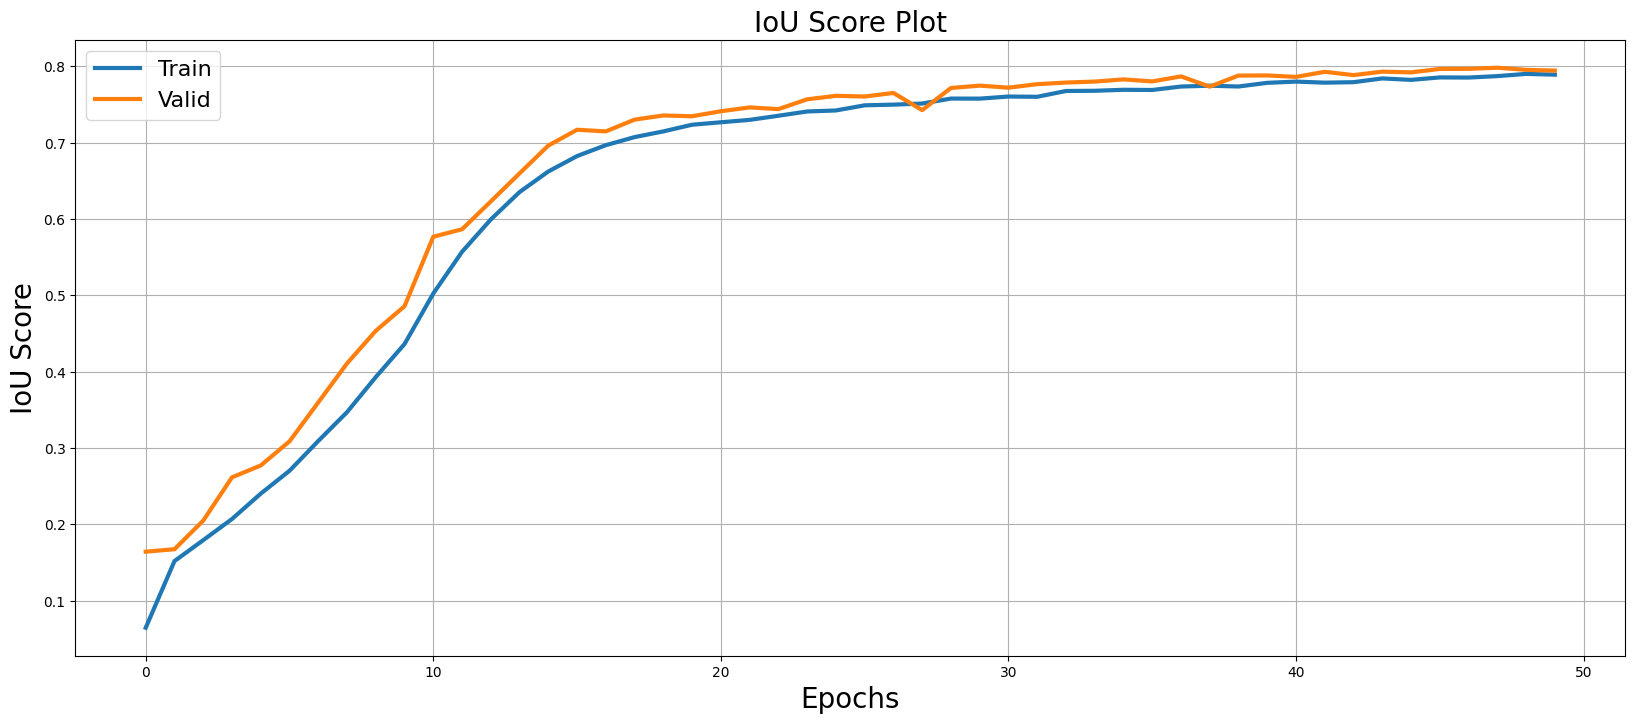

In [20]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

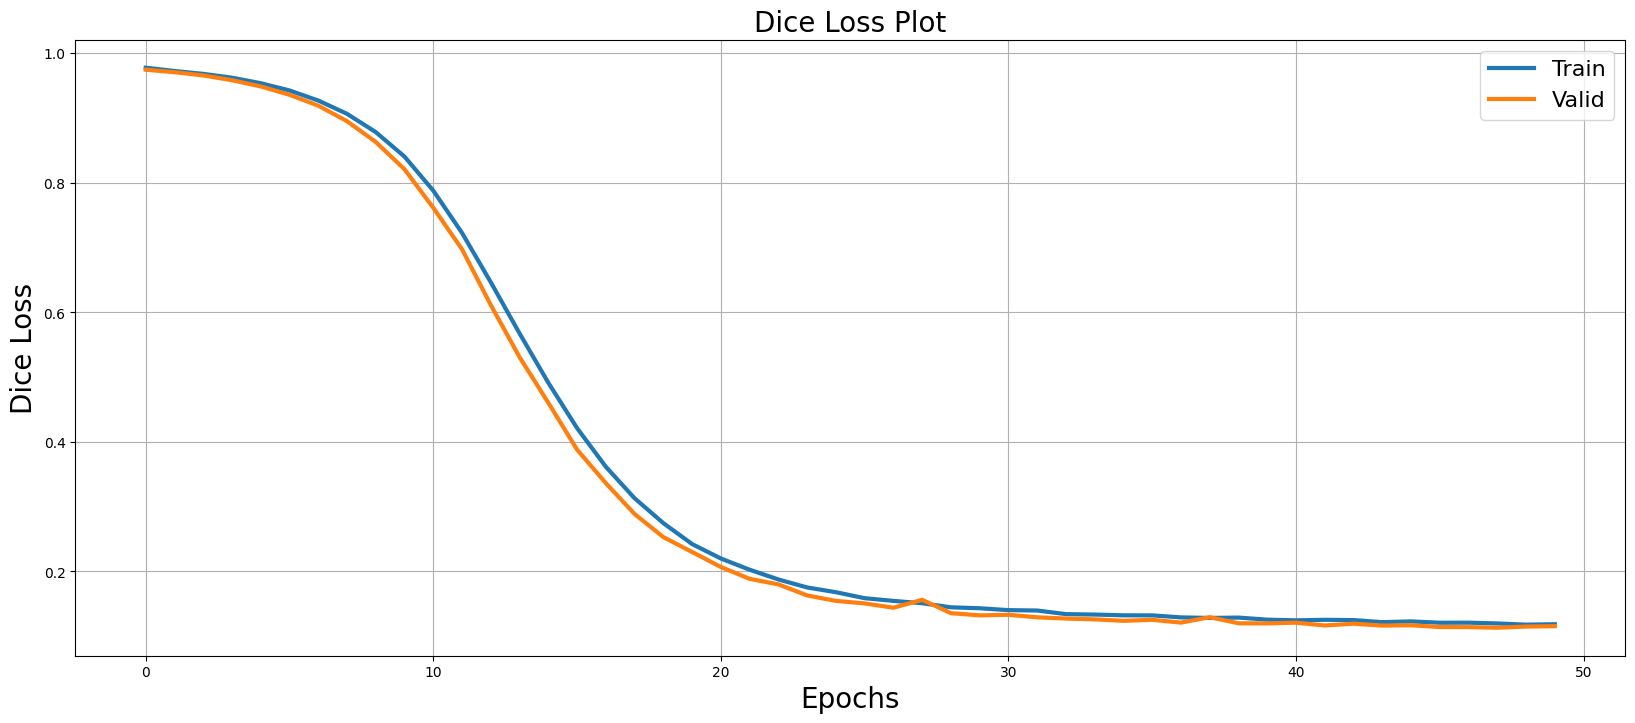

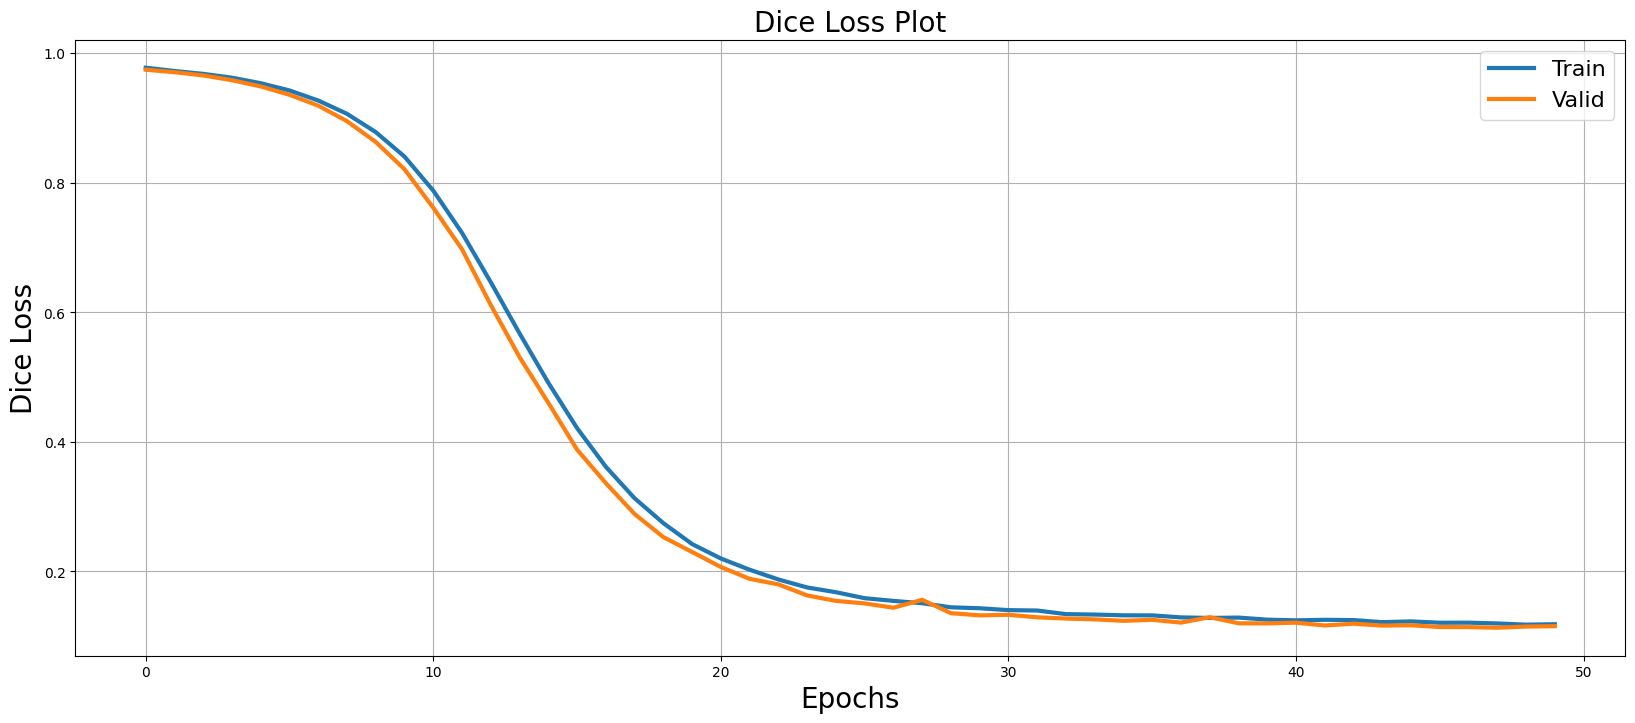

In [21]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()